In [37]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [38]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

# print("Path to dataset files:", path)

In [39]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [40]:
annotation_1 = "face-mask-detection/versions/1/annotations/maksssksksss0.xml"
df_sample = pd.DataFrame(parse_xml(annotation_1))
df_sample

,filename,label,bbox
0,maksssksksss0.png,without_mask,"{'xmin': 79, 'ymin': 105, 'xmax': 109, 'ymax':..."
1,maksssksksss0.png,with_mask,"{'xmin': 185, 'ymin': 100, 'xmax': 226, 'ymax'..."
2,maksssksksss0.png,without_mask,"{'xmin': 325, 'ymin': 90, 'xmax': 360, 'ymax':..."


In [41]:
ANNOTATION_PATH = 'face-mask-detection/versions/1/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()
df


,filename,label,bbox
0,maksssksksss0.png,without_mask,"{'xmin': 79, 'ymin': 105, 'xmax': 109, 'ymax':..."
1,maksssksksss0.png,with_mask,"{'xmin': 185, 'ymin': 100, 'xmax': 226, 'ymax'..."
2,maksssksksss0.png,without_mask,"{'xmin': 325, 'ymin': 90, 'xmax': 360, 'ymax':..."
3,maksssksksss1.png,with_mask,"{'xmin': 321, 'ymin': 34, 'xmax': 354, 'ymax':..."
4,maksssksksss1.png,with_mask,"{'xmin': 224, 'ymin': 38, 'xmax': 261, 'ymax':..."
...,...,...,...
4067,maksssksksss98.png,with_mask,"{'xmin': 263, 'ymin': 62, 'xmax': 287, 'ymax':..."
4068,maksssksksss98.png,with_mask,"{'xmin': 344, 'ymin': 80, 'xmax': 377, 'ymax':..."
4069,maksssksksss99.png,mask_weared_incorrect,"{'xmin': 181, 'ymin': 54, 'xmax': 273, 'ymax':..."
4070,maksssksksss99.png,with_mask,"{'xmin': 99, 'ymin': 87, 'xmax': 176, 'ymax': ..."


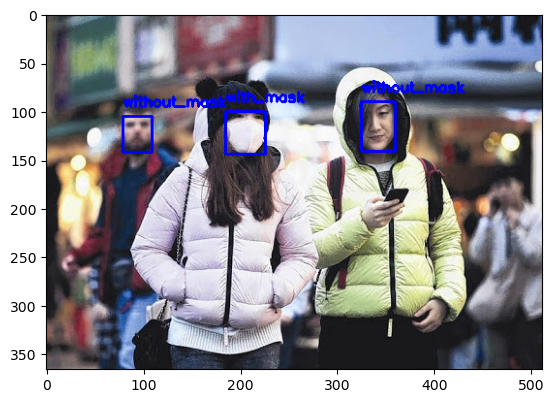

In [42]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('face-mask-detection/versions/1/images/maksssksksss0.png', parse_xml('face-mask-detection/versions/1/annotations/maksssksksss0.xml'))

In [43]:
IMAGE_PATH = 'face-mask-detection/versions/1/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [44]:
augmentation = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rotation_range = 25,
    fill_mode = 'nearest'
)


In [45]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

train_y_cat = tf.keras.utils.to_categorical(train_y)
val_y_cat = tf.keras.utils.to_categorical(val_y)
test_y_cat = tf.keras.utils.to_categorical(test_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y_cat.shape, val_y_cat.shape, test_y_cat.shape)


(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850, 3) (611, 3) (611, 3)


# MobileNetV2

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam


In [47]:
#set input shape
input_shape = (224, 224, 3)


In [48]:
# 3. Load Pretrained MobileNetV2 (Exclude Top
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze the base model initially


In [49]:
#Add Custom Classification Head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)  # 3 classes

model_mobilenetv2 = Model(inputs, outputs)


In [50]:
#Compile the model
model_mobilenetv2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## Without augmentation

In [51]:
#train the model
history_mobilenetv2 = model_mobilenetv2.fit(
    train_x, train_y_cat,
    validation_data=(val_x, val_y_cat),
    epochs=10,
    batch_size=32
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.3443 - loss: 1.6304 - val_accuracy: 0.7791 - val_loss: 0.6348
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.7520 - loss: 0.7044 - val_accuracy: 0.7921 - val_loss: 0.5577
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.7789 - loss: 0.5946 - val_accuracy: 0.8216 - val_loss: 0.4940
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.7959 - loss: 0.5430 - val_accuracy: 0.8282 - val_loss: 0.4551
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8195 - loss: 0.4793 - val_accuracy: 0.8445 - val_loss: 0.4208
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.8206 - loss: 0.4706 - val_accuracy: 0.8462 - val_loss: 0.4010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.8579 - loss: 0.4070 - val_accuracy: 0.8674 - val_loss: 0.3804
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.8417 - loss: 0.4292 - val_accu

In [52]:
#Test data
test_loss, test_acc = model_mobilenetv2.evaluate(test_x, test_y_cat)
print(f"Test accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8513 - loss: 0.3797
Test accuracy: 0.8576


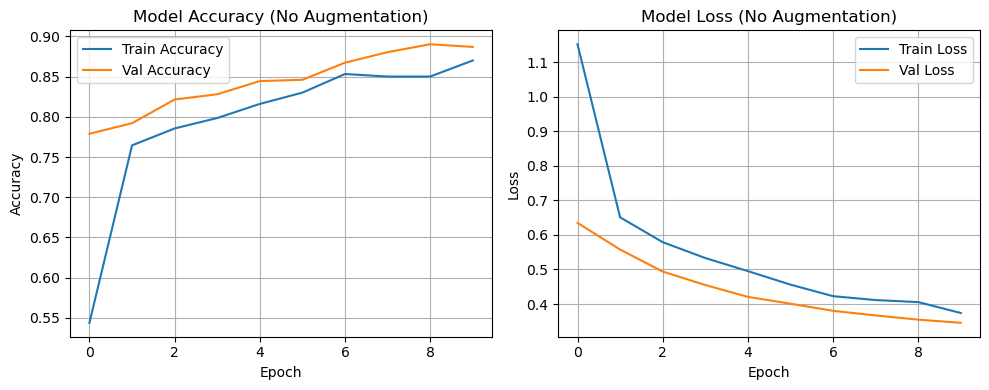

In [53]:
import matplotlib.pyplot as plt

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Val Loss')
plt.title('Model Loss (No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step


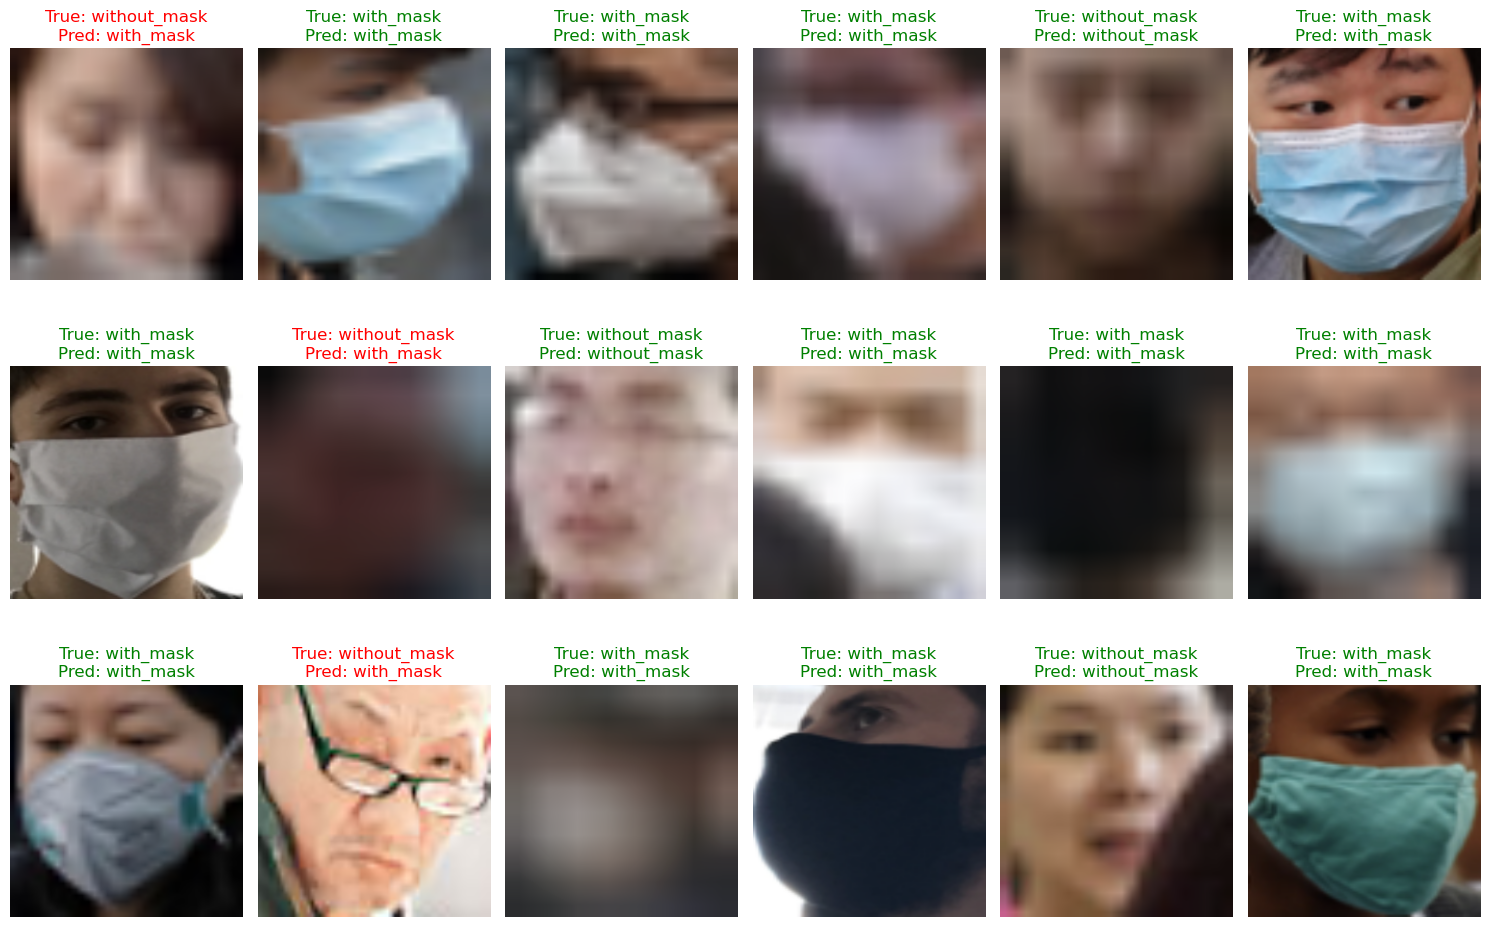

In [54]:
# Get predictions for test data
predictions = model_mobilenetv2.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_y

# Create a mapping from numeric labels back to string labels
label_mapping = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

# Plot a grid of images with their predictions
plt.figure(figsize=(15, 10))
for i in range(18):  # Show first 9 images
    plt.subplot(3, 6, i+1)
    plt.imshow(cv2.cvtColor(((test_x[i] + 1) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    true_label = label_mapping[true_labels[i]]
    pred_label = label_mapping[predicted_labels[i]]
    color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
    
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## with augmentation

In [55]:
model_mobilenetv2_aug= Model(inputs, outputs)
#Compile the model
model_mobilenetv2_aug.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
train_gen = augmentation.flow(train_x, train_y_cat, batch_size=32)

history_mobilenetv2_aug=model_mobilenetv2_aug.fit(
    train_gen,
    validation_data=(val_x, val_y_cat),
    epochs=10
)


c:\Users\joans\anaconda3\envs\deepenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.8561 - loss: 0.3874 - val_accuracy: 0.8953 - val_loss: 0.3375
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.8625 - loss: 0.3934 - val_accuracy: 0.8953 - val_loss: 0.3324
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.8525 - loss: 0.3964 - val_accuracy: 0.8969 - val_loss: 0.3316
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - accuracy: 0.8611 - loss: 0.3645 - val_accuracy: 0.8887 - val_loss: 0.3406
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.8786 - loss: 0.3465 - val_accuracy: 0.8969 - val_loss: 0.3150
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.8761 - loss: 0.3484 - val_accuracy: 0.9018 - val_loss: 0.3144
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.8710 - loss: 0.3489 - val_accuracy: 0.9051 - val_loss: 0.3100
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.8706 - loss: 0.3519 - val_accu

In [57]:
#Test data
test_loss, test_acc = model_mobilenetv2_aug.evaluate(test_x, test_y_cat)
print(f"Test accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8754 - loss: 0.3339
Test accuracy: 0.8854


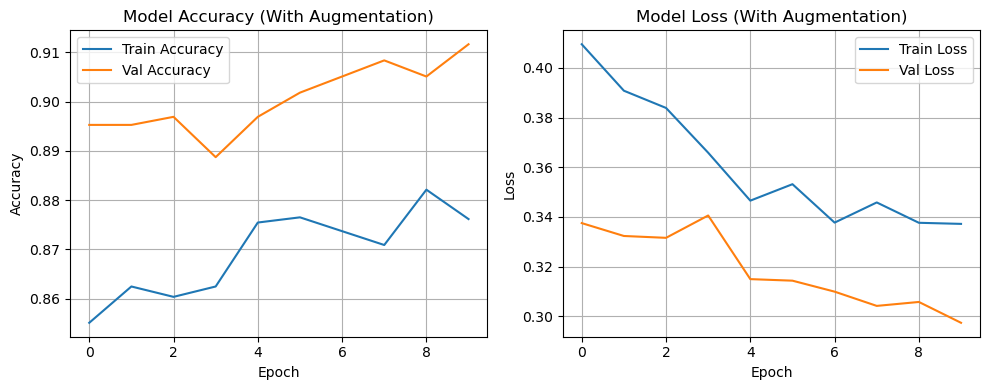

In [58]:
import matplotlib.pyplot as plt

# Accuracy Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (With Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2_aug.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2_aug.history['val_loss'], label='Val Loss')
plt.title('Model Loss (With Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step


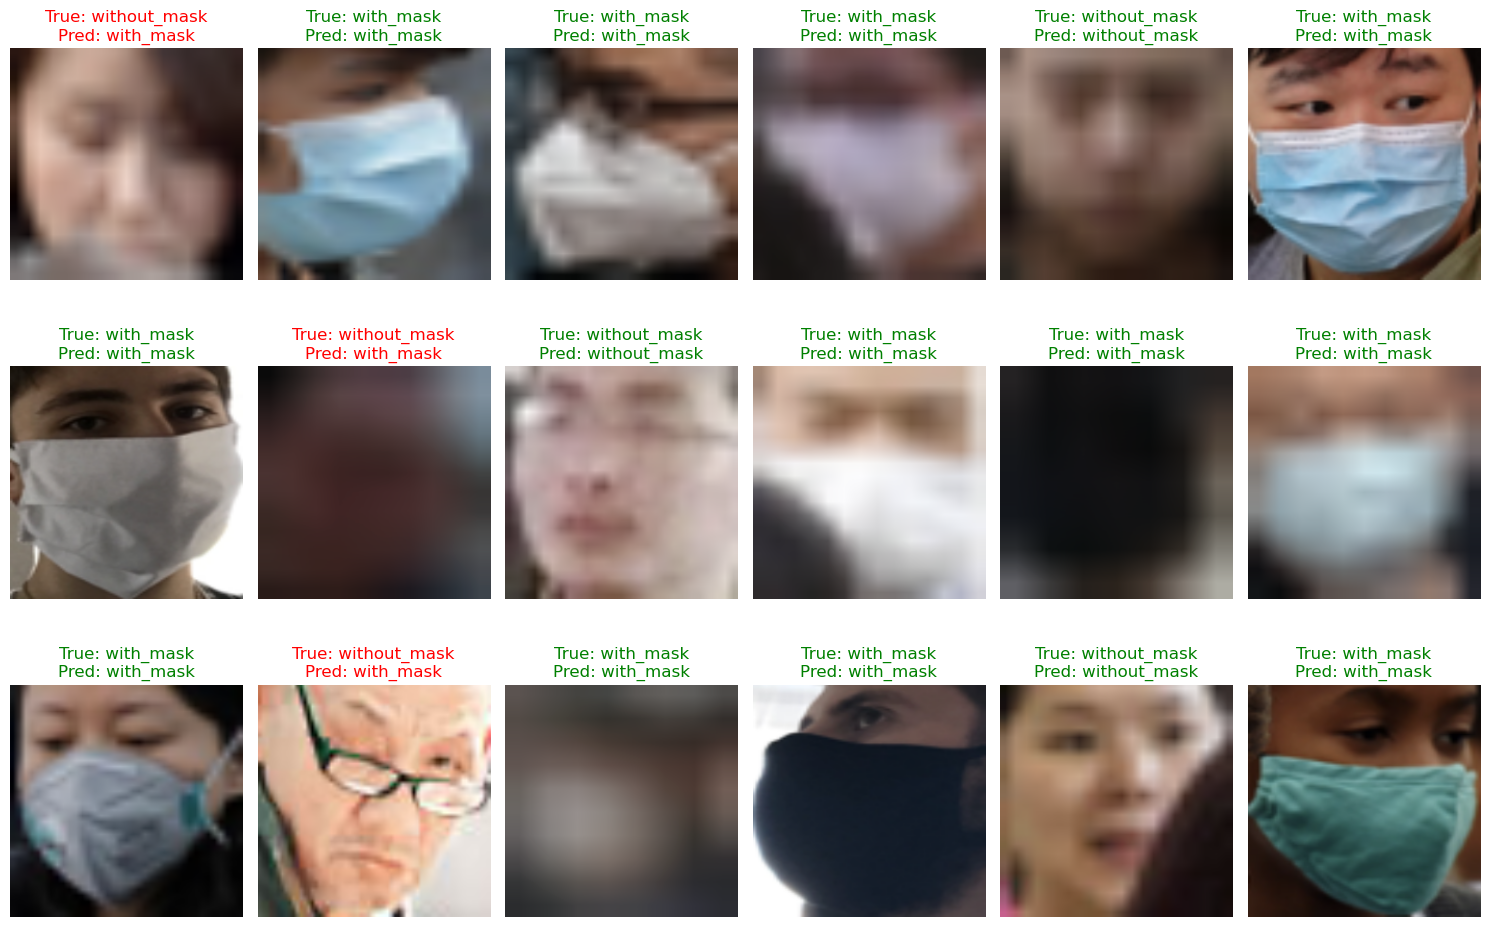

In [59]:
# Get predictions for test data
predictions = model_mobilenetv2_aug.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_y

# Create a mapping from numeric labels back to string labels
label_mapping = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

# Plot a grid of images with their predictions
plt.figure(figsize=(15, 10))
for i in range(18):  # Show first 9 images
    plt.subplot(3, 6, i+1)
    plt.imshow(cv2.cvtColor(((test_x[i] + 1) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    true_label = label_mapping[true_labels[i]]
    pred_label = label_mapping[predicted_labels[i]]
    color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
    
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()